<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MVPC" data-toc-modified-id="MVPC-1">MVPC</a></span></li><li><span><a href="#Create-simulated-dataset" data-toc-modified-id="Create-simulated-dataset-2">Create simulated dataset</a></span></li><li><span><a href="#Load-post-processed-simulated-data" data-toc-modified-id="Load-post-processed-simulated-data-3">Load post-processed simulated data</a></span></li><li><span><a href="#Visualize-our-data" data-toc-modified-id="Visualize-our-data-4">Visualize our data</a></span></li><li><span><a href="#Perform-group-level-analysis" data-toc-modified-id="Perform-group-level-analysis-5">Perform group-level analysis</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6">Conclusion</a></span></li></ul></div>

# MVPC

# Create simulated dataset

In [30]:
## Code for simulating the data: ##
import pymc3 as pm
np.random.seed(1)
num_subjects = 20
num_conditions = 2
num_voxels = 50
num_blocks = 10
data=[]

normal1 = pm.Normal.dist(mu=1.5,sigma=.5)
normal2 = pm.Normal.dist(mu=.5,sigma=.5)
unif = pm.Uniform.dist(lower=-3,upper=3)
cond1 = pm.Mixture.dist(w=[.8,.2], comp_dists=[normal1,unif])
cond2 = pm.Mixture.dist(w=[.8,.2], comp_dists=[normal2,unif])

activations=np.full(num_subjects*num_conditions*num_blocks*num_voxels,np.nan)
sub_id=np.full(num_subjects*num_conditions*num_blocks*num_voxels,np.nan)
cond_id=np.full(num_subjects*num_conditions*num_blocks*num_voxels,np.nan)
vox_id=np.full(num_subjects*num_conditions*num_blocks*num_voxels,np.nan)
block_id=np.full(num_subjects*num_conditions*num_blocks*num_voxels,np.nan)

cnt=0
for s in range(num_subjects):
    for c in range(num_conditions):
        for r in range(num_blocks):
            for v in range(num_voxels):
                if c==0:
                    activations[cnt]=cond1.random(size=1)
                else:
                    activations[cnt]=cond2.random(size=1)
                sub_id[cnt]=s
                cond_id[cnt]=c
                vox_id[cnt]=v
                block_id[cnt]=r
                trial_id[cnt]=t
                cnt+=1

np.save('activations.npy',activations)
np.save('sub_id.npy',sub_id)
np.save('cond_id.npy',cond_id)
np.save('vox_id.npy',vox_id)
np.save('block_id.npy',block_id)

# Load post-processed simulated data
Import our data. Look at how many subjects, trial conditions, and voxels we have to work with. 

Note that we follow Python conventions by numbering variables starting at 0 and not 1.

In [2]:
# general packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn import svm

# pull data from GitHub
import requests, io
for array in ['activations','sub_id','cond_id','vox_id','block_id','trial_id']:
    globals()['{}'.format(array)] = np.load(io.BytesIO(requests.get(
        'http://paulscotti.github.io/navigateFMRI/methods/mvpa/{}.npy'.format(array)).content))

# overview of the data
num_subjects = len(np.unique(sub_id)) #20
num_conditions = len(np.unique(cond_id)) #2
num_voxels = len(np.unique(vox_id)) #50
num_blocks = len(np.unique(block_id)) #4

In [3]:
# change default plotting
plt.rcParams.update({'font.size': 20, 'figure.figsize': (7,2)})

# Visualize our data

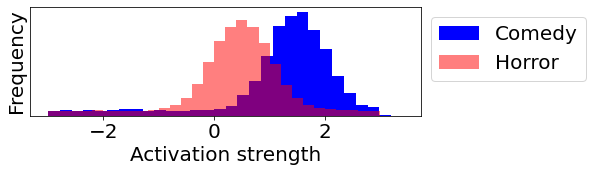

In [31]:
plt.hist(activations[cond_id==0],color='blue',bins=30,label='Comedy')
plt.hist(activations[cond_id==1],color='red',bins=30,alpha=.5,label='Horror')
plt.yticks([]);plt.ylabel('Frequency')
plt.xlabel("Activation strength")
plt.legend(bbox_to_anchor=(1, 1))
# plt.savefig("2b.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
plt.show()

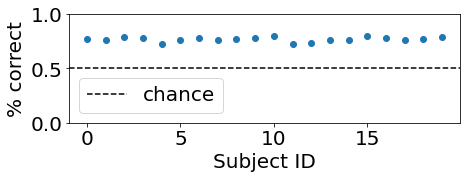

Avg correct predictions across subs: 0.7675
Above-chance prediction accuracy? (t-test):
t=61.7678, p=0.0000


In [32]:
scores=[];
for s in range(num_subjects):
    model = svm.SVC(kernel='linear')

    samples_train = activations[(sub_id==s) & (block_id%2==0)].reshape(-1, 1)
    classes_train = cond_id[(sub_id==s) & (block_id%2==0)].ravel()

    samples_test = activations[(sub_id==s) & (block_id%2==1)].reshape(-1, 1)
    classes_test = cond_id[(sub_id==s) & (block_id%2==1)].ravel()

    model.fit(samples_train,classes_train)
    scores = np.concatenate([scores,[model.score(samples_test,classes_test)]])
plt.scatter(np.arange(len(scores)),scores)
plt.ylim([.0,1.])
plt.ylabel("% correct")
plt.xlabel("Subject ID")
plt.axhline(.5,ls='--',c='k',label='chance')
plt.legend()
plt.show()
print("Avg correct predictions across subs:",np.mean(scores))
stat = sp.stats.ttest_rel(scores,np.ones(num_subjects)*.5)
print("Above-chance prediction accuracy? (t-test):\nt={:.4f}, p={:.4f}".format(stat.statistic,stat.pvalue))

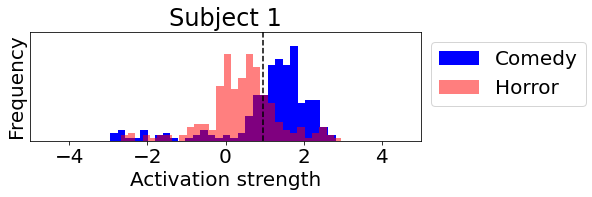

In [38]:
s=1
model = svm.SVC(kernel='linear')
samples_train = activations[(sub_id==s) & (block_id%2==0)].reshape(-1, 1)
classes_train = cond_id[(sub_id==s) & (block_id%2==0)].ravel()
samples_test = activations[(sub_id==s) & (block_id%2==1)].reshape(-1, 1)
classes_test = cond_id[(sub_id==s) & (block_id%2==1)].ravel()
model.fit(samples_train,classes_train)

plt.hist(activations[(sub_id==s) & (block_id%2==1) & (cond_id==0)],color='blue',bins=30,label='Comedy')
plt.hist(activations[(sub_id==s) & (block_id%2==1) & (cond_id==1)],color='red',bins=30,alpha=.5,label='Horror')
plt.yticks([]);plt.ylabel('Frequency')
plt.xlabel("Activation strength")
plt.legend(bbox_to_anchor=(1, 1))

xx = np.linspace(-5, 5, 100)
yy = np.linspace(0, 40, 100)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

plt.title("Subject {}".format(s))
plt.contour(XX, YY, Z, colors='k', levels=[0],
            linestyles=['--', '-', '--'])
plt.show()